<a href="https://colab.research.google.com/github/costpetrides/Fluid-Dynamics-Navier-Stokes/blob/main/PennyLane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np


__all__ = [
    "u_momentum",
    "v_momentum",
    "get_rhs",
    "get_coeff_mat",
    "pressure_correct",
    "update_velocity",
    "check_divergence_free"
]

def u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p, velocity, alpha):
    u_star = np.zeros((imax + 1, jmax))
    d_u = np.zeros((imax + 1, jmax))

    # Convective coefficients
    De = mu * dy / dx
    Dw = mu * dy / dx
    Dn = mu * dx / dy
    Ds = mu * dx / dy

    def A(F, D):
        return max(0, (1 - 0.1 * abs(F / D))**5)

    # Compute u_star
    for i in range(1, imax):
        for j in range(1, jmax - 1):
            Fe = 0.5 * rho * dy * (u[i + 1, j] + u[i, j])
            Fw = 0.5 * rho * dy * (u[i - 1, j] + u[i, j])
            Fn = 0.5 * rho * dx * (v[i, j + 1] + v[i - 1, j + 1])
            Fs = 0.5 * rho * dx * (v[i, j] + v[i - 1, j])

            aE = De * A(Fe, De) + max(-Fe, 0)
            aW = Dw * A(Fw, Dw) + max(Fw, 0)
            aN = Dn * A(Fn, Dn) + max(-Fn, 0)
            aS = Ds * A(Fs, Ds) + max(Fs, 0)
            aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)

            pressure_term = (p[i - 1, j] - p[i, j]) * dy

            u_star[i, j] = alpha / aP * ((aE * u[i + 1, j] + aW * u[i - 1, j] + aN * u[i, j + 1] + aS * u[i, j - 1]) + pressure_term) + (1 - alpha) * u[i, j]

            d_u[i, j] = alpha * dy / aP

    # Set d_u for top and bottom BCs
    for i in range(1, imax):
        j = 0  # bottom
        Fe = 0.5 * rho * dy * (u[i + 1, j] + u[i, j])
        Fw = 0.5 * rho * dy * (u[i - 1, j] + u[i, j])
        Fn = 0.5 * rho * dx * (v[i, j + 1] + v[i - 1, j + 1])
        Fs = 0

        aE = De * A(Fe, De) + max(-Fe, 0)
        aW = Dw * A(Fw, Dw) + max(Fw, 0)
        aN = Dn * A(Fn, Dn) + max(-Fn, 0)
        aS = 0
        aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
        d_u[i, j] = alpha * dy / aP

        j = jmax - 1  # top
        Fe = 0.5 * rho * dy * (u[i + 1, j] + u[i, j])
        Fw = 0.5 * rho * dy * (u[i - 1, j] + u[i, j])
        Fn = 0
        Fs = 0.5 * rho * dx * (v[i, j] + v[i - 1, j])

        aE = De * A(Fe, De) + max(-Fe, 0)
        aW = Dw * A(Fw, Dw) + max(Fw, 0)
        aN = 0
        aS = Ds * A(Fs, Ds) + max(Fs, 0)
        aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
        d_u[i, j] = alpha * dy / aP

    # Apply BCs
    u_star[0, :jmax] = -u_star[1, :jmax]            # left wall
    u_star[imax, :jmax] = -u_star[imax - 1, :jmax]  # right wall
    u_star[:, 0] = 0.0                              # bottom wall
    u_star[:, jmax - 1] = velocity                  # top wall

    return u_star, d_u

def v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p, alpha):

    v_star = np.zeros((imax, jmax+1))
    d_v = np.zeros((imax, jmax+1))

    # Convective coefficients
    De = mu * dy / dx
    Dw = mu * dy / dx
    Dn = mu * dx / dy
    Ds = mu * dx / dy

    A = lambda F, D: max(0, (1-0.1 * abs(F/D))**5)

    # Compute u_star
    for i in range(1, imax-1):
        for j in range(1, jmax):
            Fe = 0.5 * rho * dy * (u[i+1, j] + u[i+1, j-1])
            Fw = 0.5 * rho * dy * (u[i, j] + u[i, j-1])
            Fn = 0.5 * rho * dx * (v[i, j] + v[i, j+1])
            Fs = 0.5 * rho * dx * (v[i, j-1] + v[i, j])

            aE = De * A(Fe, De) + max(-Fe, 0)
            aW = Dw * A(Fw, Dw) + max(Fw, 0)
            aN = Dn * A(Fn, Dn) + max(-Fn, 0)
            aS = Ds * A(Fs, Ds) + max(Fs, 0)
            aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)

            pressure_term = (p[i, j-1] - p[i, j]) * dx

            v_star[i, j] = alpha / aP * (aE * v[i+1, j] + aW * v[i-1, j] + aN * v[i, j+1] + aS * v[i, j-1] + pressure_term) + (1-alpha) * v[i, j]

            d_v[i, j] = alpha * dx / aP

    # Set d_v for left and right BCs
    for j in range(1, jmax):
        i = 0  # left BC
        Fe = 0.5 * rho * dy * (u[i+1, j] + u[i+1, j-1])
        Fw = 0
        Fn = 0.5 * rho * dx * (v[i, j] + v[i, j+1])
        Fs = 0.5 * rho * dx * (v[i, j-1] + v[i, j])

        aE = De * A(Fe, De) + max(-Fe, 0)
        aW = 0
        aN = Dn * A(Fn, Dn) + max(-Fn, 0)
        aS = Ds * A(Fs, Ds) + max(Fs, 0)
        aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
        d_v[i, j] = alpha * dx / aP

        i = imax - 1  # right BC
        Fe = 0
        Fw = 0.5 * rho * dy * (u[i, j] + u[i, j-1])
        Fn = 0.5 * rho * dx * (v[i, j] + v[i, j+1])
        Fs = 0.5 * rho * dx * (v[i, j-1] + v[i, j])

        aE = 0
        aW = Dw * A(Fw, Dw) + max(Fw, 0)
        aN = Dn * A(Fn, Dn) + max(-Fn, 0)
        aS = Ds * A(Fs, Ds) + max(Fs, 0)
        aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
        d_v[i, j] = alpha * dx / aP

    # Apply BCs
    v_star[0, :] = 0.0  # left wall
    v_star[imax-1, :] = 0.0  # right wall
    v_star[:, 0] = -v_star[:, 1]  # bottom wall
    v_star[:, jmax] = -v_star[:, jmax-1]  # top wall

    return v_star, d_v


def get_rhs(imax, jmax, dx, dy, rho, u_star, v_star):

    stride = jmax
    bp = np.zeros((jmax) * (imax))

    # RHS is the same for all nodes except the first one
    # because the first element is set to be zero, it has no pressure correction
    for j in range(jmax):
        for i in range(imax):
            position = i + j * stride
            bp[position] = rho * (u_star[i,j] * dy - u_star[i+1,j] * dy + v_star[i,j] * dx - v_star[i,j+1] * dx)

    # modify for the first element
    bp[0] = 0

    return bp

def get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v):

    N = imax * jmax
    stride = jmax
    Ap = np.zeros((N, N))

    for j in range(jmax):
        for i in range(imax):
            position = i + j * stride
            aE, aW, aN, aS = 0, 0, 0, 0

            # Set BCs for four corners
            if i == 0 and j == 0:
                Ap[position, position] = 1
                continue

            if i == imax-1 and j == 0:
                Ap[position, position-1] = -rho * d_u[i,j] * dy
                aW = -Ap[position, position-1]
                Ap[position, position+stride] = -rho * d_v[i,j+1] * dx
                aN = -Ap[position, position+stride]
                Ap[position, position] = aE + aN + aW + aS
                continue

            if i == 0 and j == jmax-1:
                Ap[position, position+1] = -rho * d_u[i+1,j] * dy
                aE = -Ap[position, position+1]
                Ap[position, position-stride] = -rho * d_v[i,j] * dx
                aS = -Ap[position, position-stride]
                Ap[position, position] = aE + aN + aW + aS
                continue

            if i == imax-1 and j == jmax-1:
                Ap[position, position-1] = -rho * d_u[i,j] * dy
                aW = -Ap[position, position-1]
                Ap[position, position-stride] = -rho * d_v[i,j] * dx
                aS = -Ap[position, position-stride]
                Ap[position, position] = aE + aN + aW + aS
                continue

            # Set four boundaries
            if i == 0:
                Ap[position, position+1] = -rho * d_u[i+1,j] * dy
                aE = -Ap[position, position+1]
                Ap[position, position+stride] = -rho * d_v[i,j+1] * dx
                aN = -Ap[position, position+stride]
                Ap[position, position-stride] = -rho * d_v[i,j] * dx
                aS = -Ap[position, position-stride]
                Ap[position, position] = aE + aN + aW + aS
                continue

            if j == 0:
                Ap[position, position+1] = -rho * d_u[i+1,j] * dy
                aE = -Ap[position, position+1]
                Ap[position, position+stride] = -rho * d_v[i,j+1] * dx
                aN = -Ap[position, position+stride]
                Ap[position, position-1] = -rho * d_u[i,j] * dy
                aW = -Ap[position, position-1]
                Ap[position, position] = aE + aN + aW + aS
                continue

            if i == imax-1:
                Ap[position, position+stride] = -rho * d_v[i,j+1] * dx
                aN = -Ap[position, position+stride]
                Ap[position, position-stride] = -rho * d_v[i,j] * dx
                aS = -Ap[position, position-stride]
                Ap[position, position-1] = -rho * d_u[i,j] * dy
                aW = -Ap[position, position-1]
                Ap[position, position] = aE + aN + aW + aS
                continue

            if j == jmax-1:
                Ap[position, position+1] = -rho * d_u[i+1,j] * dy
                aE = -Ap[position, position+1]
                Ap[position, position-stride] = -rho * d_v[i,j] * dx
                aS = -Ap[position, position-stride]
                Ap[position, position-1] = -rho * d_u[i,j] * dy
                aW = -Ap[position, position-1]
                Ap[position, position] = aE + aN + aW + aS
                continue

            # Interior nodes
            Ap[position, position-1] = -rho * d_u[i,j] * dy
            aW = -Ap[position, position-1]

            Ap[position, position+1] = -rho * d_u[i+1,j] * dy
            aE = -Ap[position, position+1]

            Ap[position, position-stride] = -rho * d_v[i,j] * dx
            aS = -Ap[position, position-stride]

            Ap[position, position+stride] = -rho * d_v[i,j+1] * dx
            aN = -Ap[position, position+stride]

            Ap[position, position] = aE + aN + aW + aS

    return Ap


def pressure_correct(imax, jmax, rhsp, Ap, p, alpha):
    pressure = np.copy(p)  # Initial pressure
    p_prime = np.zeros((imax, jmax))  # Pressure correction matrix
    p_prime_interior = np.linalg.solve(Ap, rhsp)


    z = 0  # Adjusted the indexing to start from 0
    for j in range(jmax):
        for i in range(imax):
            p_prime[i, j] = p_prime_interior[z]
            z += 1
            pressure[i, j] = p[i, j] + alpha * p_prime[i, j]

    pressure[0, 0] = 0  # Set the pressure at the first node to zero

    return pressure, p_prime


def update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity):
    u = np.zeros((imax+1, jmax))
    v = np.zeros((imax, jmax+1))

    # Update interior nodes of u and v
    for i in range(1, imax):
        for j in range(1, jmax-1):
            u[i,j] = u_star[i,j] + d_u[i,j] * (p_prime[i-1,j] - p_prime[i,j])

    for i in range(1, imax-1):
        for j in range(1, jmax):
            v[i,j] = v_star[i,j] + d_v[i,j] * (p_prime[i,j-1] - p_prime[i,j])

    # Update BCs
    v[0,:] = 0.0          # left wall
    v[imax-1,:] = 0.0     # right wall
    v[:,0] = -v[:,1]      # bottom wall
    v[:,-1] = -v[:,-2]    # top wall

    u[0,:] = -u[1,:]      # left wall
    u[imax,:] = -u[imax-1,:] # right wall
    u[:,0] = 0.0          # bottom wall
    u[:,-1] = velocity    # top wall

    return u, v


def check_divergence_free(imax, jmax, dx, dy, u, v):
    div = np.zeros((imax, jmax))

    for i in range(imax):
        for j in range(jmax):
            div[i, j] = (1/dx) * (u[i, j] - u[i+1, j]) + (1/dy) * (v[i, j] - v[i, j+1])

    return div

In [2]:
import numpy as np
import matplotlib.pyplot as plt

imax = 30                        # grid size in x-direction
jmax = 30                        # grid size in y-direction
max_iteration = 5000             # iterations
max_res = 1000                   # initial residual
rho = 1                          # density
velocity = 1                     # velocity = lid velocity
Re = 100                         # Reynolds number
mu = 1/Re                        # kinematic viscosity = 1/Reynolds number
dx = 1 / (imax - 1)              # dx, dy cell sizes along x and y directions
dy = 1 / (jmax - 1)
x = np.arange(dx / 2, 1 + dx/2 - dx / 2, dx)
y = np.arange(0, 1+dy/2, dy)
alpha_p = 0.1                    # pressure under-relaxation
alpha_u = 0.7                    # velocity under-relaxation
tol = 1e-5

# Variable declaration
p = np.zeros((imax, jmax))             # Pressure
p_star = np.zeros((imax, jmax))        # intermediate pressure
p_prime = np.zeros((imax, jmax))       # pressure correction
rhsp = np.zeros((imax, jmax))          # right hand side vector of pressure correction equation
div = np.zeros((imax, jmax))

# Vertical velocity
v_star = np.zeros((imax, jmax + 1))    # intermediate velocity
v = np.zeros((imax, jmax + 1))         # final velocity
d_v = np.zeros((imax, jmax + 1))       # velocity correction coefficient

# Horizontal Velocity
u_star = np.zeros((imax + 1, jmax))    # intermediate velocity
u = np.zeros((imax + 1, jmax))         # final velocity
d_u = np.zeros((imax + 1, jmax))       # velocity correction coefficient


# Boundary condition
# Lid velocity (Top wall is moving with 1m/s)
u_star[:, jmax-1] = velocity
u[:, jmax-1] = velocity

In [3]:
res_hist = []

iteration = 1
# max_iteration = 10    # for debug
while iteration <= max_iteration and max_res > tol:
    iteration += 1

    # Solve u and v momentum equations for intermediate velocity
    u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alpha_u)
    v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alpha_u)

    u_old = u.copy()
    v_old = v.copy()

    # Calculate rhs vector of the Pressure Poisson matrix
    rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)

    # Form the Pressure Poisson coefficient matrix
    Ap = get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v)

    # Solve pressure correction implicitly and update pressure
    p, p_prime = pressure_correct(imax, jmax, rhsp, Ap, p_star, alpha_p)

    # Update velocity based on pressure correction
    u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity)

    # Check if velocity field is divergence free
    div = check_divergence_free(imax, jmax, dx, dy, u, v)

    p_star = p.copy()              # use p as p_star for the next iteration

    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist.append(max_res)

    # Check for convergence
    if (iteration % 50) == 0:
        print(f"Iteration = {iteration}; Residual = {max_res}")

    if max_res > 5:
        print("not going to converge!")
        break

Iteration = 50; Residual = 0.0034488613160472414
Iteration = 100; Residual = 0.0011876546378164488
Iteration = 150; Residual = 0.0005480380418994568
Iteration = 200; Residual = 0.0002892256997696317
Iteration = 250; Residual = 0.00016132454521032222
Iteration = 300; Residual = 9.20944352148581e-05
Iteration = 350; Residual = 5.294597932877648e-05
Iteration = 400; Residual = 3.0504836671260693e-05
Iteration = 450; Residual = 1.761363031166363e-05
Iteration = 500; Residual = 1.0174837544923987e-05


Final Iteration = 502; Residual = 9.953621186276074e-06


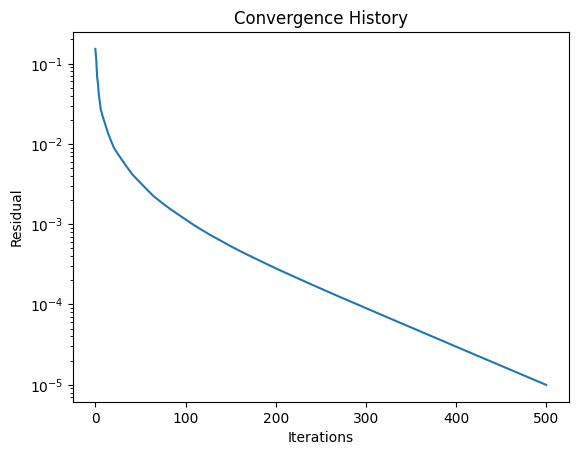

In [7]:
# Final residual
print(f"Final Iteration = {iteration}; Residual = {max_res}")
plt.plot(np.arange(iteration)[0:-1], res_hist)
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.title("Convergence History")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

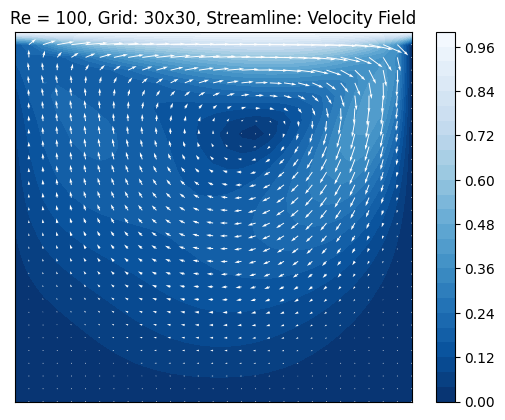

In [8]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, np.sqrt(u[1:imax,:].T**2 + v[1:imax, 0:jmax].T**2), 32, cmap='Blues_r')
plt.colorbar()
plt.quiver(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, color='w')
plt.title('Re = {0}, Grid: {1}x{2}, Streamline: Velocity Field'.format(Re, imax, jmax))
plt.xticks([])
plt.yticks([])
plt.show()

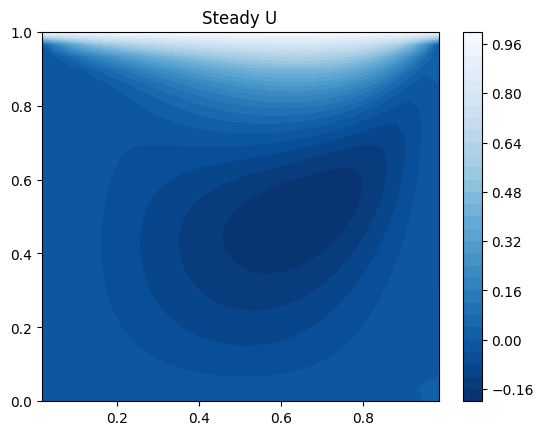

In [6]:
X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u[1:imax,:].T, 32, cmap='Blues_r')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

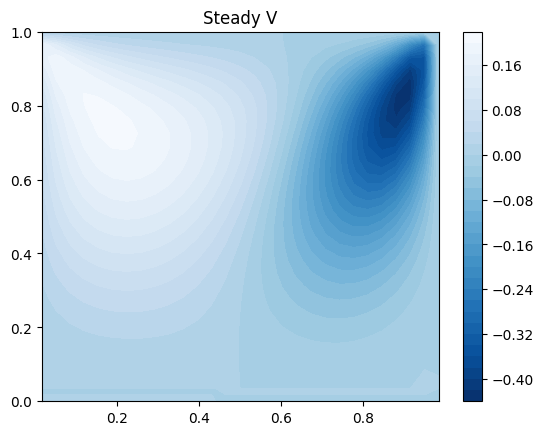

In [9]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, v[1:imax, 0:jmax].T, 32, cmap='Blues_r')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady V")
plt.show()

# PennyLane

1.

In [7]:
def normalize_b(rhs):
    norm = np.linalg.norm(rhs)
    if norm == 0:
        raise ValueError("rhs vector is zero")
    return rhs / norm

def projector_matrix(b_normalized):
    outer = np.outer(b_normalized, b_normalized)  # |b⟩⟨b|
    identity = np.eye(len(b_normalized))
    return identity - outer  # I - |b⟩⟨b|

def build_hamiltonian(Ap, rhs):
    b_norm = normalize_b(rhs)
    P = projector_matrix(b_norm)
    H = Ap.T @ P @ Ap  # Equivalent to A† (I - |b⟩⟨b|) A
    return H


In [8]:
def build_hamiltonian(Ap, rhsp):
    """
    Constructs Hermitian matrix H = A† (I - |b⟩⟨b|) A
    for use in a VQE-based quantum linear solver.

    Parameters:
        Ap   : numpy.ndarray, system matrix A (NxN)
        rhsp : numpy.ndarray, right-hand side vector b (N)

    Returns:
        H : numpy.ndarray, Hermitian matrix
    """
    norm = np.linalg.norm(rhsp)
    if norm == 0:
        raise ValueError("Right-hand side vector is zero.")
    b_hat = rhsp / norm
    projector = np.eye(len(rhsp)) - np.outer(b_hat, b_hat)
    H = Ap.T @ projector @ Ap
    return H


2.

In [11]:
import pennylane as qml
import numpy as np

def get_device(num_qubits):
    return qml.device("default.qubit", wires=num_qubits)


In [12]:
def ansatz(params, wires):
    qml.templates.StronglyEntanglingLayers(params, wires=wires)

def get_cost_function(H, dev, num_qubits, layers):
    num_params = qml.templates.StronglyEntanglingLayers.shape(n_layers=layers, n_wires=num_qubits)
    np.random.seed(42)
    init_params = np.random.normal(0, np.pi, size=num_params)

    @qml.qnode(dev)
    def circuit(params):
        ansatz(params, wires=range(num_qubits))
        return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))

    def cost_fn(params):
        return circuit(params)

    return cost_fn, init_params


In [13]:
def define_vqe_problem(H):
    """
    Sets up the quantum circuit and cost function for VQE.

    Parameters:
        H : numpy.ndarray
            The Hermitian matrix to minimize (from build_hamiltonian)

    Returns:
        cost_fn : function
            The cost function ⟨ψ(θ)|H|ψ(θ)⟩
        init_params : ndarray
            Initial random parameters
    """
    num_qubits = int(np.ceil(np.log2(H.shape[0])))  # log2 N
    dev = get_device(num_qubits)
    layers = 2  # Can be increased

    cost_fn, init_params = get_cost_function(H, dev, num_qubits, layers)

    return cost_fn, init_params, dev


In [14]:
def run_vqe_optimization(cost_fn, init_params, steps=100, lr=0.1, verbose=True):
    """
    Runs a VQE optimizer to minimize ⟨ψ|H|ψ⟩ using PennyLane.

    Parameters:
        cost_fn     : function, cost function from VQE circuit
        init_params : ndarray, initial parameters for the ansatz
        steps       : int, number of optimization steps
        lr          : float, learning rate
        verbose     : bool, print progress

    Returns:
        optimal_params : ndarray, optimized parameters
        history        : list, cost at each step
    """
    opt = qml.AdamOptimizer(stepsize=lr)
    params = init_params.copy()
    history = []

    for i in range(steps):
        params, cost = opt.step_and_cost(cost_fn, params)
        history.append(cost)

        if verbose and (i % 10 == 0 or i == steps - 1):
            print(f"Step {i+1:03d}: Cost = {cost:.8f}")

    return params, history


In [15]:
import matplotlib.pyplot as plt

def plot_vqe_history(history):
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Steps")
    plt.ylabel("Cost ⟨ψ|H|ψ⟩")
    plt.title("VQE Convergence")
    plt.grid()
    plt.show()
